In [1]:
def custom_sharpe_ratio(non_default_prob, default_prob, t_bill, term, installment, funded_amnt, rec_rate):
    """
    커스텀 샤프비율 계산 함수
    비부도 수익률과 부도 수익률을 아래 공식으로 계산:
        - 비부도 수익률 = (term * installment - funded_amnt) / funded_amnt
        - 부도 수익률 = (term * installment * rec_rate - funded_amnt) / funded_amnt
    
    기대수익률 = 비부도 확률 * 비부도 수익률 + 부도율 * 부도 수익률
    리스크(sigma) = 1 - rec_rate
    커스텀 샤프비율 = (기대수익률 - t_bill) / sigma
    
    Parameters:
    - non_default_prob: 비부도 확률 (예: 0.95)
    - default_prob: 부도율 (예: 0.05)
    - t_bill: 무위험수익률 (예: 0.02)
    - term: 대출 기간(회수 혹은 installment 횟수, 예: 36)
    - installment: 회차별 상환금액 (예: 300)
    - funded_amnt: 대출 원금 (예: 10000)
    - rec_rate: 회수율 (예: 0.4)
    
    Returns:
    - 커스텀 샤프비율 값
    """
    # 비부도 수익률 계산
    non_default_yield = (term * installment - funded_amnt) / funded_amnt
    # 부도 수익률 계산
    default_yield = (term * installment * rec_rate - funded_amnt) / funded_amnt

    # 기대수익률 계산
    expected_return = non_default_prob * non_default_yield + default_prob * default_yield

    # 리스크 측정: sigma = 1 - 회수율
    sigma = 1 - rec_rate

    # sigma가 0인 경우 에러 처리 (회수율이 1인 경우)
    if sigma == 0:
        raise ValueError("회수율이 1인 경우 sigma가 0이 되어 샤프비율을 계산할 수 없습니다.")
    
    # 커스텀 샤프비율 계산
    sharpe_ratio = (expected_return - t_bill) / sigma
    return sharpe_ratio

# 예시: 입력값에 따른 커스텀 샤프비율 계산
non_default_prob = 0.95  # 비부도 확률
default_prob = 0.05      # 부도율
t_bill = 0.02            # 무위험수익률
term = 36                # 예: 36개월
installment = 300        # 매월 상환금액
funded_amnt = 10000      # 대출 원금
rec_rate = 0.4           # 회수율

result = custom_sharpe_ratio(non_default_prob, default_prob, t_bill, term, installment, funded_amnt, rec_rate)
print("Custom Sharpe Ratio:", result)


Custom Sharpe Ratio: 0.05166666666666666


In [2]:
import pandas as pd

df = pd.read_csv("./data/trd_timeline.csv")

In [3]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
0,6000.0,6000.0,6000.0,36.0,0.0797,187.94,0,4,2.0,45000.0,...,50054.0,15000.0,56511.0,True,False,False,False,False,False,True
1,23200.0,23200.0,23200.0,60.0,0.2499,680.82,4,23,10.0,110000.0,...,294461.0,20300.0,291465.0,True,False,False,False,False,False,True
2,16000.0,16000.0,16000.0,36.0,0.0707,494.55,0,1,-1.0,65000.0,...,32551.0,59100.0,49339.0,True,False,False,False,False,False,False
3,4500.0,4500.0,4500.0,36.0,0.1042,146.10,1,7,5.0,50000.0,...,9573.0,9300.0,11970.0,True,False,False,False,False,False,False
4,20000.0,20000.0,20000.0,36.0,0.0999,645.25,1,7,10.0,60000.0,...,66283.0,11000.0,73090.0,True,False,False,False,False,True,False


In [23]:
import joblib
import pandas as pd
import xgboost as xgb  # xgboost DMatrix 사용을 위해 임포트

# 모델 로드
model_int_rate = joblib.load('./model/int_rate_pred_ridge.pkl')
model_recovery_rate = joblib.load('./model/recovery_pred_ridge.pkl')
model_loan_status = joblib.load('./model/loan_status_prop.pkl')

# 모델3의 경우 dict로 저장되어 있다면 내부 모델 객체를 추출합니다.
if isinstance(model_loan_status, dict):
    loan_status_model = model_loan_status["model"]
else:
    loan_status_model = model_loan_status

# 데이터 로드 및 불필요한 타겟 컬럼 제거
df1 = pd.read_csv("./data/test_sec_timeline_scaled.csv")
df1 = df1.drop(columns=["int_rate"])
df3 = pd.read_csv("./data/test_trd_timeline_scaled.csv")
df3 = df3.drop(columns=["loan_status"])

# =============================================================================
# 1. 모델1: df1을 넣어 int_rate 예측 후 보관
# =============================================================================
df1_out = df1.copy()  # 원본 손상 방지
# 모델1 학습 시 사용했던 피처 목록 추출
feature_list_model1 = list(model_int_rate.feature_names_in_)
# df1에서 모델1에 필요한 피처만 선택
df1_model1 = df1[feature_list_model1]
# 예측 (회귀 모델) 후 'int_rate' 칼럼 추가
df1_out['int_rate'] = model_int_rate.predict(df1_model1)
# 예측된 int_rate 칼럼 보관 (인덱스가 맞아야 함)
int_rate_pred = df1_out['int_rate']

# =============================================================================
# 2. 모델2: df2를 생성하여, 모델1의 int_rate를 피처로 포함하고 recovery_rate 예측 후 보관
# =============================================================================
df2 = df1.copy()
# 모델1 예측 결과 int_rate를 df2에 추가 (모델2의 피처로 사용될 예정)
df2['int_rate'] = int_rate_pred.values
# 모델2 학습 시 사용했던 피처 목록 추출
feature_list_model2 = list(model_recovery_rate.feature_names_in_)
# df2에서 모델2에 필요한 피처만 선택
df2_model2 = df2[feature_list_model2]
# 모델2 예측 (회귀 모델) 후 'recovery_rate' 칼럼 추가
df2['recovery_rate'] = model_recovery_rate.predict(df2_model2)
# 예측된 recovery_rate 칼럼 보관
recovery_rate_pred = df2['recovery_rate']

# =============================================================================
# 3. 모델3: df3을 넣어 부도율(loan_status, def_prob_pred) 예측
# =============================================================================
df3_out = df3.copy()
# XGBoost 모델은 DataFrame 대신 DMatrix를 입력으로 받아야 합니다.
dmat = xgb.DMatrix(df3)
# predict()가 반환하는 값은 부도 확률(여기서는 def_prob_pred)입니다.
def_prob = loan_status_model.predict(dmat)
df3_out['def_prob_pred'] = def_prob
# 일반적으로 이진 분류에서는 0.5를 기준으로 예측 클래스 생성
df3_out['loan_status'] = (def_prob > 0.5).astype(int)

# =============================================================================
# 4. df3에 보관한 두 칼럼(int_rate, recovery_rate) 붙이기
# =============================================================================
# 이미 같은 이름의 칼럼이 존재한다면, 여기서 덮어씁니다.
df3_out['int_rate'] = int_rate_pred.values
df3_out['recovery_rate'] = recovery_rate_pred.values

# 최종 결과 DataFrame (df3_out)는
# 원본 df3에 모델3 예측 결과와 함께, 모델1/모델2 예측 결과가 추가된 형태입니다.
print(df3_out.head())


   loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0   0.812055     0.812055         0.827113     0  0.207749     0.817396   
1   0.673551     0.673551         0.699705     1  0.318056     0.682735   
2   0.734053     0.734053         0.755360     0  0.216219     0.764872   
3   0.812055     0.812055         0.827113     0  0.283932     0.835438   
4   0.653631     0.653631         0.681382     0  0.285305     0.734915   

      grade  sub_grade  emp_length  annual_inc  ...  home_ownership_MORTGAGE  \
0  0.000000   0.000000    0.636364    0.656528  ...                     True   
1  0.333333   0.352941    0.090909    0.600222  ...                    False   
2  0.000000   0.000000    0.181818    0.617340  ...                     True   
3  0.166667   0.264706    0.181818    0.629166  ...                    False   
4  0.333333   0.382353    0.363636    0.604569  ...                    False   

   home_ownership_NONE  home_ownership_OTHER  home_ownership_OWN  \


In [24]:
df3_out.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,...,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,def_prob_pred,loan_status,recovery_rate
0,0.812055,0.812055,0.827113,0,0.207749,0.817396,0.000000,0.000000,0.636364,0.656528,...,True,False,False,False,False,True,False,0.020124,0,0.936837
1,0.673551,0.673551,0.699705,1,0.318056,0.682735,0.333333,0.352941,0.090909,0.600222,...,False,False,False,False,True,True,False,0.671099,1,0.967298
2,0.734053,0.734053,0.755360,0,0.216219,0.764872,0.000000,0.000000,0.181818,0.617340,...,True,False,False,False,False,False,False,0.000649,0,0.937574
3,0.812055,0.812055,0.827113,0,0.283932,0.835438,0.166667,0.264706,0.181818,0.629166,...,False,False,False,True,False,False,True,0.016711,0,0.995375
4,0.653631,0.653631,0.681382,0,0.285305,0.734915,0.333333,0.382353,0.363636,0.604569,...,False,False,False,False,True,True,False,0.043970,0,0.988677


In [31]:
import numpy as np
import pandas as pd

def compute_custom_sharpe_on_df3_out(df3_out, t_bill):
    """
    df3_out에 있는 데이터를 이용해 커스텀 샤프비율을 계산하고, 
    그 결과를 'custom_sharpe_ratio' 칼럼으로 추가합니다.
    
    전제:
      - df3_out에 아래 칼럼들이 존재해야 합니다.
          'int_rate'          : 모델1 예측 이자율 (연이율)
          'recovery_rate'     : 모델2 예측 회수율
          'def_prob_pred'     : 모델3 예측 부도 확률 (클래스1 확률)
          'term'              : 대출 기간 (0이면 36개월, 1이면 60개월로 매핑됨)
          'funded_amnt'       : 대출 원금
      - t_bill: 무위험수익률 (예: 0.0432)
      
    funded_amnt가 0인 경우 해당 행은 커스텀 샤프비율을 0으로 매핑하며,
    term 값은 0이면 36개월(3년), 1이면 60개월(5년)으로 변환하여 계산합니다.
    """
    
    def convert_term_to_years(mapped_term):
        """term이 0이면 3년, 1이면 5년, 그 외에는 그대로 반환"""
        if mapped_term == 0:
            return 3
        elif mapped_term == 1:
            return 5
        else:
            return mapped_term  # 이미 년 단위라면 그대로 사용

    def calc_installment(row):
        int_rate = row['int_rate']   # 연이율라고 가정
        actual_term_years = convert_term_to_years(row['term'])
        funded_amnt = row['funded_amnt']
        # actual_term_years이나 funded_amnt가 0이면 계산 불가 -> NaN 반환
        if actual_term_years == 0 or funded_amnt == 0:
            return np.nan
        if int_rate == 0:
            return funded_amnt / actual_term_years
        else:
            # installment 계산: 대출원금 * 이자율 / (1 - (1 + 이자율)^(-기간))
            return funded_amnt * int_rate / (1 - (1 + int_rate) ** (-actual_term_years))
    
    def calc_sharp(row):
        funded_amnt = row['funded_amnt']
        if funded_amnt == 0 or pd.isna(row['installment']):
            return 0.0
        
        actual_term_years = convert_term_to_years(row['term'])
        installment = row['installment']
        
        # 비부도 수익률 계산
        non_default_yield = (actual_term_years * installment - funded_amnt) / funded_amnt
        # 부도 수익률 계산
        default_yield = (actual_term_years * installment * row['recovery_rate'] - funded_amnt) / funded_amnt
        # 기대수익률 계산
        expected_return = (1 - row['def_prob_pred']) * non_default_yield + row['def_prob_pred'] * default_yield
        # 리스크 sigma 계산
        sigma = 1 - row['recovery_rate']
        
        if sigma == 0:
            return 0.0
        
        return (expected_return - t_bill) / sigma
    
    # installment 계산 후 df3_out에 저장
    df3_out['installment'] = df3_out.apply(calc_installment, axis=1)
    
    # 각 행마다 커스텀 샤프비율 계산 후 'custom_sharpe_ratio' 칼럼에 저장
    df3_out['custom_sharpe_ratio'] = df3_out.apply(calc_sharp, axis=1)
    
    return df3_out

# 예시 사용:
# t_bill 값을 0.0432 (4.32%)로 설정하여 df3_out에 커스텀 샤프비율 계산 결과를 추가합니다.
df3_out = compute_custom_sharpe_on_df3_out(df3_out, t_bill=0.0432)
print(df3_out[['custom_sharpe_ratio']].head())


   custom_sharpe_ratio
0             6.276680
1            31.632784
2             6.683351
3           123.530101
4            50.680266


In [32]:
df3_out.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,...,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,def_prob_pred,loan_status,recovery_rate,custom_sharpe_ratio
0,0.812055,0.812055,0.827113,0,0.207749,0.390189,0.000000,0.000000,0.636364,0.656528,...,False,False,False,False,True,False,0.020124,0,0.936837,6.276680
1,0.673551,0.673551,0.699705,1,0.318056,0.286162,0.333333,0.352941,0.090909,0.600222,...,False,False,False,True,True,False,0.671099,1,0.967298,31.632784
2,0.734053,0.734053,0.755360,0,0.216219,0.357356,0.000000,0.000000,0.181818,0.617340,...,False,False,False,False,False,False,0.000649,0,0.937574,6.683351
3,0.812055,0.812055,0.827113,0,0.283932,0.437072,0.166667,0.264706,0.181818,0.629166,...,False,False,True,False,False,True,0.016711,0,0.995375,123.530101
4,0.653631,0.653631,0.681382,0,0.285305,0.352494,0.333333,0.382353,0.363636,0.604569,...,False,False,False,True,True,False,0.043970,0,0.988677,50.680266


In [36]:
import numpy as np
import pandas as pd

def compute_custom_sharpe_on_df3_out_new(df3_out, t_bill):
    """
    df3_out의 데이터를 이용해 커스텀 샤프비율을 계산하고, 
    그 결과를 'custom_sharpe_ratio' 칼럼으로 추가한 후, 
    로그 스케일(custom_sharpe_ratio_log)로 변환하여 극단값을 완화합니다.
    
    전제:
      - df3_out에는 아래 칼럼들이 존재해야 합니다.
          'int_rate'          : 모델1 예측 이자율 (연이율)
          'recovery_rate'     : 모델2 예측 회수율
          'def_prob_pred'     : 모델3 예측 부도 확률 (클래스1 확률)
          'term'              : 대출 기간 (0이면 36개월, 1이면 60개월로 매핑되어 있음)
          'funded_amnt'       : 대출 원금
      - t_bill: 무위험수익률 (예: 0.0432)
      
    여기서는 분모로 (비부도 수익률 - 부도 수익률)을 사용하여 계산하며,
    funded_amnt가 0인 경우 해당 행은 샤프비율을 0으로, 그리고 최종 계산 후
    로그 변환을 적용합니다.
    
    로그 변환은 다음과 같이 적용합니다:
      - 값이 양수이면 log(value)
      - 값이 음수이면 -log(abs(value))
      - 0이면 0 그대로
    """
    
    def convert_term_to_years(mapped_term):
        """term이 0이면 36개월 -> 3년, 1이면 60개월 -> 5년, 그 외에는 그대로 사용"""
        if mapped_term == 0:
            return 3
        elif mapped_term == 1:
            return 5
        else:
            return mapped_term

    def calc_installment(row):
        int_rate = row['int_rate']   # 연이율로 가정
        actual_term_years = convert_term_to_years(row['term'])
        funded_amnt = row['funded_amnt']
        # actual_term_years이나 funded_amnt가 0이면 계산 불가 -> NaN 반환
        if actual_term_years == 0 or funded_amnt == 0:
            return np.nan
        if int_rate == 0:
            return funded_amnt / actual_term_years
        else:
            return funded_amnt * int_rate / (1 - (1 + int_rate) ** (-actual_term_years))
    
    def calc_sharp(row):
        funded_amnt = row['funded_amnt']
        if funded_amnt == 0 or pd.isna(row['installment']):
            return 0.0
        
        actual_term_years = convert_term_to_years(row['term'])
        installment = row['installment']
        
        # 비부도 수익률 계산
        non_default_yield = (actual_term_years * installment - funded_amnt) / funded_amnt
        # 부도 수익률 계산
        default_yield = (actual_term_years * installment * row['recovery_rate'] - funded_amnt) / funded_amnt
        # 기대수익률 계산
        expected_return = (1 - row['def_prob_pred']) * non_default_yield + row['def_prob_pred'] * default_yield
        
        # 새로운 분모: 비부도 수익률 - 부도 수익률
        denom = non_default_yield - default_yield
        
        if denom == 0:
            return 0.0
        
        return (expected_return - t_bill) / denom
    
    # installment 계산 후 df3_out에 저장
    df3_out['installment'] = df3_out.apply(calc_installment, axis=1)
    
    # 각 행마다 커스텀 샤프비율 계산 후 'custom_sharpe_ratio' 칼럼에 저장
    df3_out['custom_sharpe_ratio'] = df3_out.apply(calc_sharp, axis=1)
    
    # 로그 스케일 변환: 값이 양수이면 log(value), 음수이면 -log(|value|)
    def log_transform(x):
        if x > 0:
            return np.log(x)
        elif x < 0:
            return -np.log(abs(x))
        else:
            return 0.0

    df3_out['custom_sharpe_ratio_log'] = df3_out['custom_sharpe_ratio'].apply(log_transform)
    
    return df3_out

# 예시 사용:
# t_bill 값을 0.0432 (4.32%)로 설정하여 df3_out에 커스텀 샤프비율 및 로그 변환 결과를 추가합니다.
df3_out = compute_custom_sharpe_on_df3_out_new(df3_out, t_bill=0.0432)
print(df3_out[['custom_sharpe_ratio', 'custom_sharpe_ratio_log']].head())


   custom_sharpe_ratio  custom_sharpe_ratio_log
0             4.354309                 1.471166
1            14.891043                 2.700760
2             4.576145                 1.520857
3            76.504066                 4.337344
4            31.325555                 3.444434


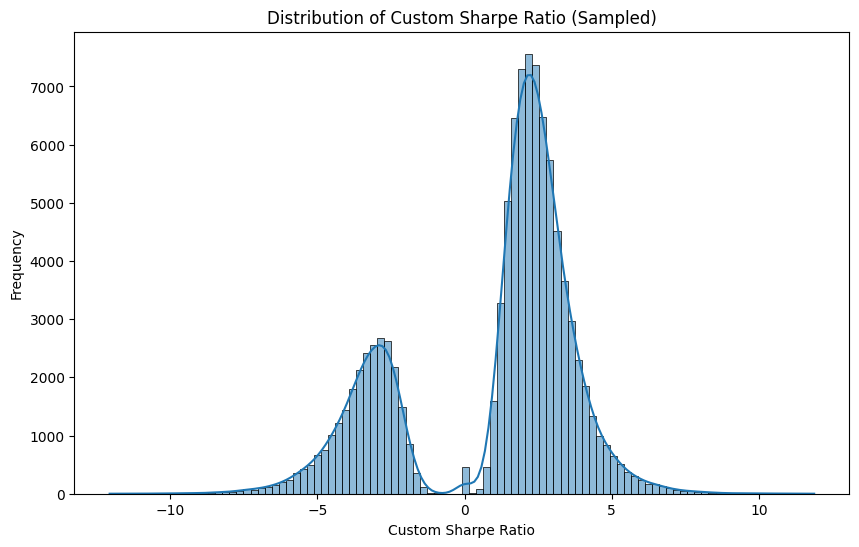

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# custom_sharpe_ratio 컬럼의 결측치 제외
sharp_vals = df3_out['custom_sharpe_ratio_log'].dropna()

# 전체 데이터 건수가 많으면 샘플링 (예: 최대 100,000개)
max_samples = 100000
if len(sharp_vals) > max_samples:
    sharp_sample = sharp_vals.sample(n=max_samples, random_state=42)
else:
    sharp_sample = sharp_vals

plt.figure(figsize=(10, 6))
sns.histplot(sharp_sample, bins=100, kde=True)
plt.title('Distribution of Custom Sharpe Ratio (Sampled)')
plt.xlabel('Custom Sharpe Ratio')
plt.ylabel('Frequency')
plt.show()
